# Example: Creating a surrogate model

This notebook covers an example on how to create a surrogate model. The notebook assumes that the device has been already tested, and that adequate voltage ranges have been found. You are strongly recommended to do this before creating a surrogate model. You can perform these adjustments by followin the explanation of notebook 0-Checking device functionality.  

The notebook is divided into two main parts. 1. Data acquisition & preprocessing, and 2. Training. Each part has different prerequisites.


**Prerequisites of 1. Data acquisition & preprocessing:**
- You have a device dipped in one of the National Instruments setups- You have successfully installed brains-py and brains-py tasks
- You have completed a previous exercise for determining adequate voltage ranges (notebook 0-Checking device functionality), or you already have the activation electrode ranges that work for the device.
- You know which are the activation electrodes for the device.
- You are familiar with obtaining the IV curves of devices, as explained in Notebook 1.

**Prerequisites of 2. Training:**
- You have a training, validation and test sets in the form of postprocessed_data.npz    

**Read this carefully before starting with the notebook**

This notebook has created to be run on BRAINS computer. The computer should be connected to the National Instruments setup consisting of a chassis and several modules. The setup should be connected to a hardware device. If you have this or a similar setup to the one just mentioned, you should run the cells that mention: "# HARDWARE_MODE" on top of them, while avoiding to run cells that mention "# SIMULATION_MODE" on them. If you not running this test in a BRAINS computer, you should change the configurations according to how your national instruments are connected. The names of the national instruments modules can be checked on the NI MAX tool. The following values should at least be updated when in a new computer with different modules (you can jump directly to the following cell):

* "trigger_source": "cDAQ1/segment1", # This particular one makes reference to the NI Chassis allocated at cDAQ1, and the trigger source segment1. Find the different triggers you can use with your own NI module in the NI MAX tools. 
* "activation_instrument": "cDAQ1Mod3", # This refers to the module of the chassis that will be used for sending inputs to the device, in this case Mod3
* "activation channels": [0,1,2,3,4,5,6], # Typically the 7 activation electrode inputs, as connected to the national instruments setup 
* "readout_instrument": "cDAQ1Mod4", # This refers to the module of the chassis that will be used for readoung outputs from the device, in this case Mod4
* "readout_channels": [0] # Typically the single readout electrode of the device

**THIS NOTEBOOK CAN ONLY BE RUN WITH A COMPUTER CONNECTED TO NATIONAL INSTRUMENTS**

In [58]:
TRIGGER_SOURCE = 'cDAQ2'
ACTIVATION_INSTRUMENT = 'cDAQ2Mod1'
ACTIVATION_CHANNELS = [4, 3, 5, 2, 0, 7, 1]
READOUT_INSTRUMENT = 'cDAQ2Mod8'
READOUT_CHANNELS = [3]
ACTIVATION_VOLTAGE_RANGES = [
            [-0.35, 0.15], # Electrode 0
            [-1.2, 0.8],
            [-1.2, 1.2],
            [-1.2, 1.2],
            [-1.2, 1.2],
            [-1.2, 0.8],
            [-0.35, 0.2], # Electrode 6
          ]

In [59]:
import os

from IPython import display

from bspysmg.data.sampling import Sampler
from bspysmg.data.postprocess import post_process
from bspysmg.model.training import generate_surrogate_model

The following configurations are not used within the program, but since configuration information is passed to the surrogate model, it can provide useful information on what device and setup were used, as well as how the electrodes were connected to the physical channels of National Instruments:

<h1> PART 1. DATA ACQUISITION & PREPROCESSING </h1>

<h2> 1.1 Configurations for data acquisition </h2>

In [60]:
configs = {
    'save_directory':  'tmp/smg', # Directory where all the data for this exercise will be stored. 
    'data_name': 'jupyter_notebook_examples' # Brief descriptive string that will be used to identify the data produced from other similar runs of the program.
}

In [61]:
input_data_configs = {

  'input_distribution': 'sawtooth', # Desired data shape for data sampling. Sawtooth or sinewave. Sawtooth provides better coverage for data close to the extremes of the activation voltage ranges

  'activation_electrode_no': 7, # Number of inputs to the device;
  # activation_electrode_no = #control_electrodes + #input_electrodes

  'readout_electrode_no': 1, # Number of output(s) specificed for the device;
  # Note: Multplie output device requires dedicated PCB and setup configuration.

  'input_frequency': [2, 3, 5, 7, 13, 17, 19], # Input frequencies;
  # These need to be prime numbers. They will be square rooted and multiplied by factor.
  
  'random_phase_shift_each': 1, # Indicates after how many batches the phase of the input data will be randomly shifted.
  #'phase': [0.,  0.,  0., 0.,  0., 0., 0.], # Initial desired phase. If random phase shift = number of batches, then the indicated phase would be used for the whole data sampling.
  
  
  # Amplitude and offset are calculated from the voltage_ranges specified in the driver/instrument_setup configs field. Alternatively, they can also be determined in these configs, as follows: 
  # Amplitude: [0.55, 0.95, 0.95, 0.95, 0.95, 0.95, 0.55] # Example
  # Offset: [-0.15,-0.25,-0.25,-0.25,-0.25,-0.25,-0.15] # Example

  'ramp_time': 0.4, # Ammount of time used to ramp up and down each of the batches. From zero to the first point and from the last point to zero, in order to ensure that the device is not damaged.

  'batch_time': 0.5, #50 # Batch time in seconds. This is used to calculate the batch_size (batch_time * sampling_frequency), 
                # which is, in turn,  used to calculate the total number of samples (total_sample_no * batch_size). 
                # By default 50, with a sampling frequency of 50 Hz. 
                # A standard value to calculate this is: 50*50/activation_frequency
                
  'number_batches': 38 # Default value: 3880

}
configs['input_data'] = input_data_configs

In [62]:
driver_configs = {
        'instrument_type': 'cdaq_to_cdaq',
        'inverted_output': True, # Whether if the op-amp circuit to amplify the output of the DNPU applies an inversion or not.
        'amplification': [41], # Indicates the amplification correction factor that will be applied to obtain the real current measurement from the setup. More information about this can be found in Section 5.3 of the introduction of brains-py wiki: https://github.com/BraiNEdarwin/brains-py/wiki/A.-Introduction
        'instruments_setup':{ 
            'multiple_devices': False, # Indicates whether if the setup is using a PCB with multiple devices or not.
            'trigger_source': TRIGGER_SOURCE, # Triggering signal to be sent for reading synchronisation. You can check for this signal for your setup on the NIMax app.
            'average_io_point_difference': True, # If number of points read from the device is different from the number of points written to the device due to a difference in their
                                                # sampling frequencies, this variable indicates if there should be an averaging so that the input and output have the same length.
            'activation_instrument': ACTIVATION_INSTRUMENT, # Main module used for sending voltage signals to the DNPU 
            'activation_sampling_frequency': 5000, # Number of samples that will be written to the DNPU in one second.
            'activation_channels': ACTIVATION_CHANNELS, # Channels of the module that will be used for sending signals the device. 
            'activation_voltage_ranges': # Maximum minimum and maximum voltage ranges that will be allowed to be sent to the DNPU, per electrode. Dimensions (Electrode_no, 2)
              ACTIVATION_VOLTAGE_RANGES,
            'readout_instrument': READOUT_INSTRUMENT, # Main module used for receiving voltage signals from the DNPU (after the op-amp) 
            'readout_sampling_frequency': 10000, # Number of samples that will be read from the DNPU in one second
            'readout_channels': [0], # Channels of the module that will be used for reading signals from the device. 
            'activation_channel_mask': [1, 1, 1, 1, 1, 1, 1] # Whether if all the channels connected to the device electrodes would be used or not. 1 for enabling its use, 0 for disabling it. When disabled, the channels will not be declared.
        }
    
    }

configs['driver'] = driver_configs

In [63]:
setup_insights = {
  #does not take effect on measurements, for documenting purposes.
  'gain_info': '50MOhm', # Feedback resistance of Op. Amp; 
  'schematic': "\t   ao5   ao3   ao4\n \t    #     #     #\n\tao2 #           # output\n     \t    #     #     #\n\t   ao0   ao7   ao1\n",
  'setup_name': 'quick',
  'device_comments': 'One electrode might not working properly (Electode works fine, but this is an exaple of how this can be filled).',
  'device_material': 'Boron doped silicon'
}
configs['setup_insights'] = setup_insights
print(setup_insights['schematic'])

	   ao5   ao3   ao4
 	    #     #     #
	ao2 #           # output
     	    #     #     #
	   ao0   ao7   ao1



<h2> 1.2. Theory </h2>

The first process of data acquisiton is related to obtaining the optimal control voltage ranges. Since this is a process that has a multi-dimensional input space, it is difficult to predict how the whole device will behave. IV curves help gauging how the device will behave. You can have more information about how to measure IV curves in Notebook 1. 

The first step for checking the control ranges is to check the distribution of the device. Let us gather a couple of samples (10-15), to have a look at the distribution of the data of the device. 

In [64]:
# HARDWARE_MODE
configs['input_data']['number_batches'] = 15
sampler = Sampler(configs)

DAC sampling frequency: 5000
ADC sampling frequency: 10000
DAC/ADC point difference: 2
Max ramping time: 0.1 seconds. 
Amplitude: [0.25  1.    1.2   1.2   1.2   1.    0.275]
Offset: [-0.1   -0.2    0.     0.     0.    -0.2   -0.075]


In [65]:
data_dir = sampler.sample()

Saving in tmp/smg
Start batching...
Outputs collection for batch 1 of 15 took 1.6942782402038574 sec. Estimated time left: 0:00:23
Outputs collection for batch 2 of 15 took 1.656968116760254 sec. Estimated time left: 0:00:21
Outputs collection for batch 3 of 15 took 1.659621000289917 sec. Estimated time left: 0:00:19
Outputs collection for batch 4 of 15 took 1.656125783920288 sec. Estimated time left: 0:00:18
Outputs collection for batch 5 of 15 took 1.6533522605895996 sec. Estimated time left: 0:00:16
Outputs collection for batch 6 of 15 took 1.6550376415252686 sec. Estimated time left: 0:00:14
Outputs collection for batch 7 of 15 took 1.6488988399505615 sec. Estimated time left: 0:00:13
Outputs collection for batch 8 of 15 took 1.6422607898712158 sec. Estimated time left: 0:00:11
Outputs collection for batch 9 of 15 took 1.6600728034973145 sec. Estimated time left: 0:00:09
Outputs collection for batch 10 of 15 took 1.6711311340332031 sec. Estimated time left: 0:00:08
Outputs collecti

In [66]:
os.listdir(data_dir)

['example_batch.png', 'IO.dat', 'sampler_configs.json']

The sampling produces an IO.dat text file, containing comma separated values of all the sampling data gathered for inputs and outputs. It also save the configurations used on the sampler. For each sample, the sampler produces an input/output plot like the one shown below: 

In [67]:
display.Image(url= os.path.join(data_dir,"example_batch.png"))

In order to get more information about the distribution of the data, the postprocessing can be applied, as follows:

In [68]:
inputs, outputs, info_dict = post_process(data_dir)


Loading file: tmp/smg\jupyter_notebook_examples_2022_08_17_143218\IO.dat
This may take some time. Please wait.

Number of raw samples:  37500
Output scales: [Min., Max.] = [43.041083993590306, 69.86311941609132]
Lower bound input scales: [-0.34998509 -1.19992616 -1.1999845  -1.19998336 -1.19993977 -1.1999024
 -0.34997178]
Upper bound input scales: [0.14999426 0.79999508 1.19996533 1.19979105 1.19982449 0.7999553
 0.19997892]

Charging signal contains 40 batches. Total time: 0:00:20
Data saved to: tmp/smg\jupyter_notebook_examples_2022_08_17_143218\charging_signal.npz

Reference signal contains 15 batches. Total time: 0:00:07
Data saved to: tmp/smg\jupyter_notebook_examples_2022_08_17_143218\reference_batch.npz

The following data is inferred from the input data. Please check if it is correct. 
Data is gathered from a device with 8 electrodes, from which: 
There are 7 activation electrodes: 
	 * Lower bound of voltage ranges: [-0.35       -1.2        -1.2        -1.2        -1.2       

In [69]:
os.listdir(data_dir)

['charging_signal.npz',
 'example_batch.png',
 'IO.dat',
 'output_distribution.png',
 'postprocessed_data.npz',
 'reference_batch.npz',
 'sampler_configs.json']

This produces a numpy file with inputs/outputs and sampling configs files, as well as data for the info dictionary:

In [70]:
info_dict['electrode_info']

{'electrode_no': 8,
 'activation_electrodes': {'electrode_no': 7,
  'voltage_ranges': array([[-0.35      ,  0.15      ],
         [-1.2       ,  0.8       ],
         [-1.2       ,  1.2       ],
         [-1.2       ,  1.2       ],
         [-1.2       ,  1.2       ],
         [-1.2       ,  0.8       ],
         [-0.35000002,  0.2       ]], dtype=float32)},
 'output_electrodes': {'electrode_no': 1,
  'amplification': [41],
  'clipping_value': [-164, 164]}}

It also produces a histogram of the sampled data. An ideal distribution would be a perfectly normal (gaussian distribution) of outputs, meaning that the current voltage ranges produce a nice coverage of the output space, that is also easier to learn for the neural network.

In [71]:
display.Image(url= os.path.join(data_dir,"output_distribution.png"))

You can repeat the exercise with different activation voltage ranges. You can change them by modifying configs['driver']['activation_voltage_ranges'] variable in the dictionary and starting another sampler instance with the new configs, until the output distribution looks more like a normal distribution. Finding optimal ranges is an empirical process, and can differ device from device. Once the optimal activation voltage range has been found, the final data can be gathered. The recommended batch size is 3880.


In [16]:
configs = original_configs.copy()
configs['input_data']['number_batches'] = 3880
sampler = Sampler(configs)
data_dir = sampler.sample()
#inputs, outputs, info_dict = post_process(data_dir)

DAC sampling frequency: 5000
ADC sampling frequency: 10000
DAC/ADC point difference: 2
Max ramping time: 0.1 seconds. 
Saving in tmp/smg
Start batching...
Outputs collection for batch 1 of 3880 took 1.6796011924743652 sec. Estimated time left: 1:48:35
Outputs collection for batch 2 of 3880 took 1.6626098155975342 sec. Estimated time left: 1:47:27
Outputs collection for batch 3 of 3880 took 1.6536009311676025 sec. Estimated time left: 1:46:51
Outputs collection for batch 4 of 3880 took 1.6585087776184082 sec. Estimated time left: 1:47:08
Outputs collection for batch 5 of 3880 took 1.6448380947113037 sec. Estimated time left: 1:46:13
Outputs collection for batch 6 of 3880 took 1.6382908821105957 sec. Estimated time left: 1:45:46
Outputs collection for batch 7 of 3880 took 1.6518168449401855 sec. Estimated time left: 1:46:37
Outputs collection for batch 8 of 3880 took 1.642275333404541 sec. Estimated time left: 1:45:58
Outputs collection for batch 9 of 3880 took 1.6509668827056885 sec. Es

Outputs collection for batch 84 of 3880 took 1.6438772678375244 sec. Estimated time left: 1:44:00
Outputs collection for batch 85 of 3880 took 1.6660833358764648 sec. Estimated time left: 1:45:22
Outputs collection for batch 86 of 3880 took 1.6343438625335693 sec. Estimated time left: 1:43:20
Outputs collection for batch 87 of 3880 took 1.650728702545166 sec. Estimated time left: 1:44:21
Outputs collection for batch 88 of 3880 took 1.6396737098693848 sec. Estimated time left: 1:43:37
Outputs collection for batch 89 of 3880 took 1.6440346240997314 sec. Estimated time left: 1:43:52
Outputs collection for batch 90 of 3880 took 1.6462295055389404 sec. Estimated time left: 1:43:59
Outputs collection for batch 91 of 3880 took 1.651798963546753 sec. Estimated time left: 1:44:18
Outputs collection for batch 92 of 3880 took 1.641507625579834 sec. Estimated time left: 1:43:38
Outputs collection for batch 93 of 3880 took 1.6390538215637207 sec. Estimated time left: 1:43:27
Outputs collection for 

Outputs collection for batch 168 of 3880 took 1.6586246490478516 sec. Estimated time left: 1:42:36
Outputs collection for batch 169 of 3880 took 1.6567349433898926 sec. Estimated time left: 1:42:28
Outputs collection for batch 170 of 3880 took 1.6498472690582275 sec. Estimated time left: 1:42:00
Outputs collection for batch 171 of 3880 took 1.6463165283203125 sec. Estimated time left: 1:41:46
Outputs collection for batch 172 of 3880 took 1.6500186920166016 sec. Estimated time left: 1:41:58
Outputs collection for batch 173 of 3880 took 1.6332435607910156 sec. Estimated time left: 1:40:54
Outputs collection for batch 174 of 3880 took 1.6482234001159668 sec. Estimated time left: 1:41:48
Outputs collection for batch 175 of 3880 took 1.6483790874481201 sec. Estimated time left: 1:41:47
Outputs collection for batch 176 of 3880 took 1.6479496955871582 sec. Estimated time left: 1:41:44
Outputs collection for batch 177 of 3880 took 1.6462137699127197 sec. Estimated time left: 1:41:35
Outputs co

Outputs collection for batch 251 of 3880 took 1.6469066143035889 sec. Estimated time left: 1:39:36
Outputs collection for batch 252 of 3880 took 1.6627309322357178 sec. Estimated time left: 1:40:32
Outputs collection for batch 253 of 3880 took 1.6497142314910889 sec. Estimated time left: 1:39:43
Outputs collection for batch 254 of 3880 took 1.6350443363189697 sec. Estimated time left: 1:38:48
Outputs collection for batch 255 of 3880 took 1.6550853252410889 sec. Estimated time left: 1:39:59
Outputs collection for batch 256 of 3880 took 1.6432125568389893 sec. Estimated time left: 1:39:15
Outputs collection for batch 257 of 3880 took 1.6498403549194336 sec. Estimated time left: 1:39:37
Outputs collection for batch 258 of 3880 took 1.6438050270080566 sec. Estimated time left: 1:39:13
Outputs collection for batch 259 of 3880 took 1.6705055236816406 sec. Estimated time left: 1:40:48
Outputs collection for batch 260 of 3880 took 1.6469898223876953 sec. Estimated time left: 1:39:22
Outputs co

Outputs collection for batch 334 of 3880 took 1.64811110496521 sec. Estimated time left: 1:37:24
Outputs collection for batch 335 of 3880 took 1.6470162868499756 sec. Estimated time left: 1:37:18
Outputs collection for batch 336 of 3880 took 1.6407034397125244 sec. Estimated time left: 1:36:54
Outputs collection for batch 337 of 3880 took 1.6455864906311035 sec. Estimated time left: 1:37:10
Outputs collection for batch 338 of 3880 took 1.6462922096252441 sec. Estimated time left: 1:37:11
Outputs collection for batch 339 of 3880 took 1.647451400756836 sec. Estimated time left: 1:37:13
Outputs collection for batch 340 of 3880 took 1.6474509239196777 sec. Estimated time left: 1:37:11
Outputs collection for batch 341 of 3880 took 1.6382579803466797 sec. Estimated time left: 1:36:37
Outputs collection for batch 342 of 3880 took 1.6373059749603271 sec. Estimated time left: 1:36:32
Outputs collection for batch 343 of 3880 took 1.6473469734191895 sec. Estimated time left: 1:37:06
Outputs colle

Outputs collection for batch 417 of 3880 took 1.6447267532348633 sec. Estimated time left: 1:34:55
Outputs collection for batch 418 of 3880 took 1.640594244003296 sec. Estimated time left: 1:34:39
Outputs collection for batch 419 of 3880 took 1.6611888408660889 sec. Estimated time left: 1:35:49
Outputs collection for batch 420 of 3880 took 1.6622507572174072 sec. Estimated time left: 1:35:51
Outputs collection for batch 421 of 3880 took 1.6367387771606445 sec. Estimated time left: 1:34:21
Outputs collection for batch 422 of 3880 took 1.6443898677825928 sec. Estimated time left: 1:34:46
Outputs collection for batch 423 of 3880 took 1.6553683280944824 sec. Estimated time left: 1:35:22
Outputs collection for batch 424 of 3880 took 1.6787803173065186 sec. Estimated time left: 1:36:41
Outputs collection for batch 425 of 3880 took 1.655125617980957 sec. Estimated time left: 1:35:18
Outputs collection for batch 426 of 3880 took 1.640455961227417 sec. Estimated time left: 1:34:26
Outputs colle

Outputs collection for batch 501 of 3880 took 1.646073341369629 sec. Estimated time left: 1:32:42
Outputs collection for batch 502 of 3880 took 1.6369264125823975 sec. Estimated time left: 1:32:09
Outputs collection for batch 503 of 3880 took 1.6537177562713623 sec. Estimated time left: 1:33:04
Outputs collection for batch 504 of 3880 took 1.6432557106018066 sec. Estimated time left: 1:32:27
Outputs collection for batch 505 of 3880 took 1.6413538455963135 sec. Estimated time left: 1:32:19
Outputs collection for batch 506 of 3880 took 1.6644742488861084 sec. Estimated time left: 1:33:35
Outputs collection for batch 507 of 3880 took 1.6363086700439453 sec. Estimated time left: 1:31:59
Outputs collection for batch 508 of 3880 took 1.6440634727478027 sec. Estimated time left: 1:32:23
Outputs collection for batch 509 of 3880 took 1.6590471267700195 sec. Estimated time left: 1:33:12
Outputs collection for batch 510 of 3880 took 1.6341567039489746 sec. Estimated time left: 1:31:47
Outputs col

Outputs collection for batch 584 of 3880 took 1.6542725563049316 sec. Estimated time left: 1:30:52
Outputs collection for batch 585 of 3880 took 1.6423707008361816 sec. Estimated time left: 1:30:11
Outputs collection for batch 586 of 3880 took 1.6584758758544922 sec. Estimated time left: 1:31:03
Outputs collection for batch 587 of 3880 took 1.665027379989624 sec. Estimated time left: 1:31:22
Outputs collection for batch 588 of 3880 took 1.6442039012908936 sec. Estimated time left: 1:30:12
Outputs collection for batch 589 of 3880 took 1.6406400203704834 sec. Estimated time left: 1:29:59
Outputs collection for batch 590 of 3880 took 1.6455063819885254 sec. Estimated time left: 1:30:13
Outputs collection for batch 591 of 3880 took 1.6752910614013672 sec. Estimated time left: 1:31:50
Outputs collection for batch 592 of 3880 took 1.6404075622558594 sec. Estimated time left: 1:29:53
Outputs collection for batch 593 of 3880 took 1.6395041942596436 sec. Estimated time left: 1:29:49
Outputs col

Outputs collection for batch 667 of 3880 took 1.6414012908935547 sec. Estimated time left: 1:27:53
Outputs collection for batch 668 of 3880 took 1.643327236175537 sec. Estimated time left: 1:27:58
Outputs collection for batch 669 of 3880 took 1.6301648616790771 sec. Estimated time left: 1:27:14
Outputs collection for batch 670 of 3880 took 1.663691759109497 sec. Estimated time left: 1:29:00
Outputs collection for batch 671 of 3880 took 1.6514403820037842 sec. Estimated time left: 1:28:19
Outputs collection for batch 672 of 3880 took 1.6648457050323486 sec. Estimated time left: 1:29:00
Outputs collection for batch 673 of 3880 took 1.6620895862579346 sec. Estimated time left: 1:28:50
Outputs collection for batch 674 of 3880 took 1.6539084911346436 sec. Estimated time left: 1:28:22
Outputs collection for batch 675 of 3880 took 1.643284559249878 sec. Estimated time left: 1:27:46
Outputs collection for batch 676 of 3880 took 1.6565220355987549 sec. Estimated time left: 1:28:27
Outputs colle

Outputs collection for batch 750 of 3880 took 1.6430437564849854 sec. Estimated time left: 1:25:42
Outputs collection for batch 751 of 3880 took 1.6356463432312012 sec. Estimated time left: 1:25:17
Outputs collection for batch 752 of 3880 took 1.6474502086639404 sec. Estimated time left: 1:25:53
Outputs collection for batch 753 of 3880 took 1.6648814678192139 sec. Estimated time left: 1:26:46
Outputs collection for batch 754 of 3880 took 1.663116455078125 sec. Estimated time left: 1:26:38
Outputs collection for batch 755 of 3880 took 1.6501226425170898 sec. Estimated time left: 1:25:56
Outputs collection for batch 756 of 3880 took 1.6355969905853271 sec. Estimated time left: 1:25:09
Outputs collection for batch 757 of 3880 took 1.6477479934692383 sec. Estimated time left: 1:25:45
Outputs collection for batch 758 of 3880 took 1.6421208381652832 sec. Estimated time left: 1:25:26
Outputs collection for batch 759 of 3880 took 1.657325267791748 sec. Estimated time left: 1:26:12
Outputs coll

Outputs collection for batch 833 of 3880 took 1.6438984870910645 sec. Estimated time left: 1:23:28
Outputs collection for batch 834 of 3880 took 1.6517972946166992 sec. Estimated time left: 1:23:51
Outputs collection for batch 835 of 3880 took 1.639251470565796 sec. Estimated time left: 1:23:11
Outputs collection for batch 836 of 3880 took 1.6400065422058105 sec. Estimated time left: 1:23:12
Outputs collection for batch 837 of 3880 took 1.6471326351165771 sec. Estimated time left: 1:23:32
Outputs collection for batch 838 of 3880 took 1.6475839614868164 sec. Estimated time left: 1:23:31
Outputs collection for batch 839 of 3880 took 1.645519733428955 sec. Estimated time left: 1:23:24
Outputs collection for batch 840 of 3880 took 1.6542551517486572 sec. Estimated time left: 1:23:48
Outputs collection for batch 841 of 3880 took 1.653303623199463 sec. Estimated time left: 1:23:44
Outputs collection for batch 842 of 3880 took 1.644200325012207 sec. Estimated time left: 1:23:15
Outputs collec

Outputs collection for batch 917 of 3880 took 1.6449544429779053 sec. Estimated time left: 1:21:14
Outputs collection for batch 918 of 3880 took 1.6430189609527588 sec. Estimated time left: 1:21:06
Outputs collection for batch 919 of 3880 took 1.6560783386230469 sec. Estimated time left: 1:21:43
Outputs collection for batch 920 of 3880 took 1.6469371318817139 sec. Estimated time left: 1:21:14
Outputs collection for batch 921 of 3880 took 1.6608688831329346 sec. Estimated time left: 1:21:54
Outputs collection for batch 922 of 3880 took 1.6367547512054443 sec. Estimated time left: 1:20:41
Outputs collection for batch 923 of 3880 took 1.66310715675354 sec. Estimated time left: 1:21:57
Outputs collection for batch 924 of 3880 took 1.6603238582611084 sec. Estimated time left: 1:21:47
Outputs collection for batch 925 of 3880 took 1.6356773376464844 sec. Estimated time left: 1:20:33
Outputs collection for batch 926 of 3880 took 1.651062250137329 sec. Estimated time left: 1:21:17
Outputs colle

Outputs collection for batch 1000 of 3880 took 1.652916669845581 sec. Estimated time left: 1:19:20
Outputs collection for batch 1001 of 3880 took 1.6475152969360352 sec. Estimated time left: 1:19:03
Outputs collection for batch 1002 of 3880 took 1.6449663639068604 sec. Estimated time left: 1:18:54
Outputs collection for batch 1003 of 3880 took 1.6522104740142822 sec. Estimated time left: 1:19:13
Outputs collection for batch 1004 of 3880 took 1.6725120544433594 sec. Estimated time left: 1:20:10
Outputs collection for batch 1005 of 3880 took 1.6532647609710693 sec. Estimated time left: 1:19:13
Outputs collection for batch 1006 of 3880 took 1.662752389907837 sec. Estimated time left: 1:19:38
Outputs collection for batch 1007 of 3880 took 1.6448941230773926 sec. Estimated time left: 1:18:45
Outputs collection for batch 1008 of 3880 took 1.6366572380065918 sec. Estimated time left: 1:18:20
Outputs collection for batch 1009 of 3880 took 1.6389572620391846 sec. Estimated time left: 1:18:25
Ou

Outputs collection for batch 1083 of 3880 took 1.6678335666656494 sec. Estimated time left: 1:17:44
Outputs collection for batch 1084 of 3880 took 1.6551880836486816 sec. Estimated time left: 1:17:07
Outputs collection for batch 1085 of 3880 took 1.643951416015625 sec. Estimated time left: 1:16:34
Outputs collection for batch 1086 of 3880 took 1.6710476875305176 sec. Estimated time left: 1:17:48
Outputs collection for batch 1087 of 3880 took 1.6524572372436523 sec. Estimated time left: 1:16:55
Outputs collection for batch 1088 of 3880 took 1.658219337463379 sec. Estimated time left: 1:17:09
Outputs collection for batch 1089 of 3880 took 1.6482257843017578 sec. Estimated time left: 1:16:40
Outputs collection for batch 1090 of 3880 took 1.6417827606201172 sec. Estimated time left: 1:16:20
Outputs collection for batch 1091 of 3880 took 1.6527364253997803 sec. Estimated time left: 1:16:49
Outputs collection for batch 1092 of 3880 took 1.6746978759765625 sec. Estimated time left: 1:17:49
Ou

Outputs collection for batch 1166 of 3880 took 1.6480000019073486 sec. Estimated time left: 1:14:32
Outputs collection for batch 1167 of 3880 took 1.6351065635681152 sec. Estimated time left: 1:13:56
Outputs collection for batch 1168 of 3880 took 1.6359970569610596 sec. Estimated time left: 1:13:56
Outputs collection for batch 1169 of 3880 took 1.6373472213745117 sec. Estimated time left: 1:13:58
Outputs collection for batch 1170 of 3880 took 1.6627869606018066 sec. Estimated time left: 1:15:06
Outputs collection for batch 1171 of 3880 took 1.6633894443511963 sec. Estimated time left: 1:15:06
Outputs collection for batch 1172 of 3880 took 1.645209789276123 sec. Estimated time left: 1:14:15
Outputs collection for batch 1173 of 3880 took 1.6489520072937012 sec. Estimated time left: 1:14:23
Outputs collection for batch 1174 of 3880 took 1.6520631313323975 sec. Estimated time left: 1:14:30
Outputs collection for batch 1175 of 3880 took 1.6468653678894043 sec. Estimated time left: 1:14:14
O

Outputs collection for batch 1249 of 3880 took 1.6455821990966797 sec. Estimated time left: 1:12:09
Outputs collection for batch 1250 of 3880 took 1.636300802230835 sec. Estimated time left: 1:11:43
Outputs collection for batch 1251 of 3880 took 1.6687970161437988 sec. Estimated time left: 1:13:07
Outputs collection for batch 1252 of 3880 took 1.6543917655944824 sec. Estimated time left: 1:12:27
Outputs collection for batch 1253 of 3880 took 1.6575579643249512 sec. Estimated time left: 1:12:34
Outputs collection for batch 1254 of 3880 took 1.643979549407959 sec. Estimated time left: 1:11:57
Outputs collection for batch 1255 of 3880 took 1.656233310699463 sec. Estimated time left: 1:12:27
Outputs collection for batch 1256 of 3880 took 1.668708086013794 sec. Estimated time left: 1:12:58
Outputs collection for batch 1257 of 3880 took 1.6489014625549316 sec. Estimated time left: 1:12:05
Outputs collection for batch 1258 of 3880 took 1.642453908920288 sec. Estimated time left: 1:11:46
Outpu

Outputs collection for batch 1332 of 3880 took 1.6396164894104004 sec. Estimated time left: 1:09:37
Outputs collection for batch 1333 of 3880 took 1.6438140869140625 sec. Estimated time left: 1:09:46
Outputs collection for batch 1334 of 3880 took 1.636775255203247 sec. Estimated time left: 1:09:27
Outputs collection for batch 1335 of 3880 took 1.655677080154419 sec. Estimated time left: 1:10:13
Outputs collection for batch 1336 of 3880 took 1.6478326320648193 sec. Estimated time left: 1:09:52
Outputs collection for batch 1337 of 3880 took 1.6622459888458252 sec. Estimated time left: 1:10:27
Outputs collection for batch 1338 of 3880 took 1.643437147140503 sec. Estimated time left: 1:09:37
Outputs collection for batch 1339 of 3880 took 1.6510295867919922 sec. Estimated time left: 1:09:55
Outputs collection for batch 1340 of 3880 took 1.6450278759002686 sec. Estimated time left: 1:09:38
Outputs collection for batch 1341 of 3880 took 1.6677381992340088 sec. Estimated time left: 1:10:34
Out

Outputs collection for batch 1415 of 3880 took 1.6519179344177246 sec. Estimated time left: 1:07:51
Outputs collection for batch 1416 of 3880 took 1.6666624546051025 sec. Estimated time left: 1:08:26
Outputs collection for batch 1417 of 3880 took 1.6572344303131104 sec. Estimated time left: 1:08:01
Outputs collection for batch 1418 of 3880 took 1.6390743255615234 sec. Estimated time left: 1:07:15
Outputs collection for batch 1419 of 3880 took 1.6653027534484863 sec. Estimated time left: 1:08:18
Outputs collection for batch 1420 of 3880 took 1.648256778717041 sec. Estimated time left: 1:07:34
Outputs collection for batch 1421 of 3880 took 1.6535797119140625 sec. Estimated time left: 1:07:46
Outputs collection for batch 1422 of 3880 took 1.6556520462036133 sec. Estimated time left: 1:07:49
Outputs collection for batch 1423 of 3880 took 1.6414871215820312 sec. Estimated time left: 1:07:13
Outputs collection for batch 1424 of 3880 took 1.65608811378479 sec. Estimated time left: 1:07:47
Out

Outputs collection for batch 1498 of 3880 took 1.6603708267211914 sec. Estimated time left: 1:05:55
Outputs collection for batch 1499 of 3880 took 1.6414432525634766 sec. Estimated time left: 1:05:08
Outputs collection for batch 1500 of 3880 took 1.6449167728424072 sec. Estimated time left: 1:05:14
Outputs collection for batch 1501 of 3880 took 1.6567480564117432 sec. Estimated time left: 1:05:41
Outputs collection for batch 1502 of 3880 took 1.6406641006469727 sec. Estimated time left: 1:05:01
Outputs collection for batch 1503 of 3880 took 1.6560864448547363 sec. Estimated time left: 1:05:36
Outputs collection for batch 1504 of 3880 took 1.6672570705413818 sec. Estimated time left: 1:06:01
Outputs collection for batch 1505 of 3880 took 1.640533447265625 sec. Estimated time left: 1:04:56
Outputs collection for batch 1506 of 3880 took 1.6452488899230957 sec. Estimated time left: 1:05:05
Outputs collection for batch 1507 of 3880 took 1.640587329864502 sec. Estimated time left: 1:04:53
Ou

Outputs collection for batch 1581 of 3880 took 1.6428077220916748 sec. Estimated time left: 1:02:56
Outputs collection for batch 1582 of 3880 took 1.6497564315795898 sec. Estimated time left: 1:03:11
Outputs collection for batch 1583 of 3880 took 1.6392223834991455 sec. Estimated time left: 1:02:45
Outputs collection for batch 1584 of 3880 took 1.6670811176300049 sec. Estimated time left: 1:03:47
Outputs collection for batch 1585 of 3880 took 1.6508252620697021 sec. Estimated time left: 1:03:08
Outputs collection for batch 1586 of 3880 took 1.6535661220550537 sec. Estimated time left: 1:03:13
Outputs collection for batch 1587 of 3880 took 1.6685340404510498 sec. Estimated time left: 1:03:45
Outputs collection for batch 1588 of 3880 took 1.6849331855773926 sec. Estimated time left: 1:04:21
Outputs collection for batch 1589 of 3880 took 1.6556317806243896 sec. Estimated time left: 1:03:13
Outputs collection for batch 1590 of 3880 took 1.6514298915863037 sec. Estimated time left: 1:03:01


Outputs collection for batch 1664 of 3880 took 1.6545472145080566 sec. Estimated time left: 1:01:06
Outputs collection for batch 1665 of 3880 took 1.6629438400268555 sec. Estimated time left: 1:01:23
Outputs collection for batch 1666 of 3880 took 1.6523776054382324 sec. Estimated time left: 1:00:58
Outputs collection for batch 1667 of 3880 took 1.659782886505127 sec. Estimated time left: 1:01:13
Outputs collection for batch 1668 of 3880 took 1.6605000495910645 sec. Estimated time left: 1:01:13
Outputs collection for batch 1669 of 3880 took 1.6641080379486084 sec. Estimated time left: 1:01:19
Outputs collection for batch 1670 of 3880 took 1.6591331958770752 sec. Estimated time left: 1:01:06
Outputs collection for batch 1671 of 3880 took 1.6723718643188477 sec. Estimated time left: 1:01:34
Outputs collection for batch 1672 of 3880 took 1.647552251815796 sec. Estimated time left: 1:00:37
Outputs collection for batch 1673 of 3880 took 1.6603200435638428 sec. Estimated time left: 1:01:04
Ou

Outputs collection for batch 1747 of 3880 took 1.6612367630004883 sec. Estimated time left: 0:59:03
Outputs collection for batch 1748 of 3880 took 1.6528682708740234 sec. Estimated time left: 0:58:43
Outputs collection for batch 1749 of 3880 took 1.654221534729004 sec. Estimated time left: 0:58:45
Outputs collection for batch 1750 of 3880 took 1.6431925296783447 sec. Estimated time left: 0:58:20
Outputs collection for batch 1751 of 3880 took 1.6570217609405518 sec. Estimated time left: 0:58:47
Outputs collection for batch 1752 of 3880 took 1.6644988059997559 sec. Estimated time left: 0:59:02
Outputs collection for batch 1753 of 3880 took 1.6476151943206787 sec. Estimated time left: 0:58:24
Outputs collection for batch 1754 of 3880 took 1.6554896831512451 sec. Estimated time left: 0:58:39
Outputs collection for batch 1755 of 3880 took 1.6506483554840088 sec. Estimated time left: 0:58:27
Outputs collection for batch 1756 of 3880 took 1.661752462387085 sec. Estimated time left: 0:58:49
Ou

Outputs collection for batch 1830 of 3880 took 1.640803575515747 sec. Estimated time left: 0:56:03
Outputs collection for batch 1831 of 3880 took 1.6616525650024414 sec. Estimated time left: 0:56:44
Outputs collection for batch 1832 of 3880 took 1.6474218368530273 sec. Estimated time left: 0:56:13
Outputs collection for batch 1833 of 3880 took 1.6518652439117432 sec. Estimated time left: 0:56:21
Outputs collection for batch 1834 of 3880 took 1.661698818206787 sec. Estimated time left: 0:56:39
Outputs collection for batch 1835 of 3880 took 1.6543622016906738 sec. Estimated time left: 0:56:23
Outputs collection for batch 1836 of 3880 took 1.6640536785125732 sec. Estimated time left: 0:56:41
Outputs collection for batch 1837 of 3880 took 1.6548712253570557 sec. Estimated time left: 0:56:20
Outputs collection for batch 1838 of 3880 took 1.6576156616210938 sec. Estimated time left: 0:56:24
Outputs collection for batch 1839 of 3880 took 1.6660780906677246 sec. Estimated time left: 0:56:40
Ou

Outputs collection for batch 1913 of 3880 took 1.6509735584259033 sec. Estimated time left: 0:54:07
Outputs collection for batch 1914 of 3880 took 1.6576297283172607 sec. Estimated time left: 0:54:18
Outputs collection for batch 1915 of 3880 took 1.6475722789764404 sec. Estimated time left: 0:53:57
Outputs collection for batch 1916 of 3880 took 1.6449530124664307 sec. Estimated time left: 0:53:50
Outputs collection for batch 1917 of 3880 took 1.6679730415344238 sec. Estimated time left: 0:54:34
Outputs collection for batch 1918 of 3880 took 1.6527256965637207 sec. Estimated time left: 0:54:02
Outputs collection for batch 1919 of 3880 took 1.6670949459075928 sec. Estimated time left: 0:54:29
Outputs collection for batch 1920 of 3880 took 1.6455986499786377 sec. Estimated time left: 0:53:45
Outputs collection for batch 1921 of 3880 took 1.6565501689910889 sec. Estimated time left: 0:54:05
Outputs collection for batch 1922 of 3880 took 1.6626286506652832 sec. Estimated time left: 0:54:15


Outputs collection for batch 1996 of 3880 took 1.649345874786377 sec. Estimated time left: 0:51:47
Outputs collection for batch 1997 of 3880 took 1.6689074039459229 sec. Estimated time left: 0:52:22
Outputs collection for batch 1998 of 3880 took 1.6472699642181396 sec. Estimated time left: 0:51:40
Outputs collection for batch 1999 of 3880 took 1.6469693183898926 sec. Estimated time left: 0:51:37
Outputs collection for batch 2000 of 3880 took 1.6483471393585205 sec. Estimated time left: 0:51:38
Outputs collection for batch 2001 of 3880 took 1.6622581481933594 sec. Estimated time left: 0:52:03
Outputs collection for batch 2002 of 3880 took 1.6630847454071045 sec. Estimated time left: 0:52:03
Outputs collection for batch 2003 of 3880 took 1.6486949920654297 sec. Estimated time left: 0:51:34
Outputs collection for batch 2004 of 3880 took 1.667984962463379 sec. Estimated time left: 0:52:09
Outputs collection for batch 2005 of 3880 took 1.6580641269683838 sec. Estimated time left: 0:51:48
Ou

Outputs collection for batch 2079 of 3880 took 1.6503593921661377 sec. Estimated time left: 0:49:32
Outputs collection for batch 2080 of 3880 took 1.6533629894256592 sec. Estimated time left: 0:49:36
Outputs collection for batch 2081 of 3880 took 1.6516807079315186 sec. Estimated time left: 0:49:31
Outputs collection for batch 2082 of 3880 took 1.6687672138214111 sec. Estimated time left: 0:50:00
Outputs collection for batch 2083 of 3880 took 1.6645729541778564 sec. Estimated time left: 0:49:51
Outputs collection for batch 2084 of 3880 took 1.65678071975708 sec. Estimated time left: 0:49:35
Outputs collection for batch 2085 of 3880 took 1.6451747417449951 sec. Estimated time left: 0:49:13
Outputs collection for batch 2086 of 3880 took 1.6710500717163086 sec. Estimated time left: 0:49:57
Outputs collection for batch 2087 of 3880 took 1.6497254371643066 sec. Estimated time left: 0:49:17
Outputs collection for batch 2088 of 3880 took 1.6574738025665283 sec. Estimated time left: 0:49:30
Ou

Outputs collection for batch 2162 of 3880 took 1.667750597000122 sec. Estimated time left: 0:47:45
Outputs collection for batch 2163 of 3880 took 1.654850721359253 sec. Estimated time left: 0:47:21
Outputs collection for batch 2164 of 3880 took 1.673342227935791 sec. Estimated time left: 0:47:51
Outputs collection for batch 2165 of 3880 took 1.6524338722229004 sec. Estimated time left: 0:47:13
Outputs collection for batch 2166 of 3880 took 1.6553070545196533 sec. Estimated time left: 0:47:17
Outputs collection for batch 2167 of 3880 took 1.6622717380523682 sec. Estimated time left: 0:47:27
Outputs collection for batch 2168 of 3880 took 1.647949457168579 sec. Estimated time left: 0:47:01
Outputs collection for batch 2169 of 3880 took 1.6551971435546875 sec. Estimated time left: 0:47:12
Outputs collection for batch 2170 of 3880 took 1.6515138149261475 sec. Estimated time left: 0:47:04
Outputs collection for batch 2171 of 3880 took 1.6748244762420654 sec. Estimated time left: 0:47:42
Outp

Outputs collection for batch 2245 of 3880 took 1.6510825157165527 sec. Estimated time left: 0:44:59
Outputs collection for batch 2246 of 3880 took 1.6669607162475586 sec. Estimated time left: 0:45:23
Outputs collection for batch 2247 of 3880 took 1.6570489406585693 sec. Estimated time left: 0:45:05
Outputs collection for batch 2248 of 3880 took 1.6673181056976318 sec. Estimated time left: 0:45:21
Outputs collection for batch 2249 of 3880 took 1.6704976558685303 sec. Estimated time left: 0:45:24
Outputs collection for batch 2250 of 3880 took 1.6534321308135986 sec. Estimated time left: 0:44:55
Outputs collection for batch 2251 of 3880 took 1.6459484100341797 sec. Estimated time left: 0:44:41
Outputs collection for batch 2252 of 3880 took 1.652543544769287 sec. Estimated time left: 0:44:50
Outputs collection for batch 2253 of 3880 took 1.6491186618804932 sec. Estimated time left: 0:44:43
Outputs collection for batch 2254 of 3880 took 1.6504666805267334 sec. Estimated time left: 0:44:43
O

Outputs collection for batch 2328 of 3880 took 1.6477129459381104 sec. Estimated time left: 0:42:37
Outputs collection for batch 2329 of 3880 took 1.651571273803711 sec. Estimated time left: 0:42:41
Outputs collection for batch 2330 of 3880 took 1.6697795391082764 sec. Estimated time left: 0:43:08
Outputs collection for batch 2331 of 3880 took 1.6506354808807373 sec. Estimated time left: 0:42:36
Outputs collection for batch 2332 of 3880 took 1.6538939476013184 sec. Estimated time left: 0:42:40
Outputs collection for batch 2333 of 3880 took 1.6600449085235596 sec. Estimated time left: 0:42:48
Outputs collection for batch 2334 of 3880 took 1.6629233360290527 sec. Estimated time left: 0:42:50
Outputs collection for batch 2335 of 3880 took 1.6616575717926025 sec. Estimated time left: 0:42:47
Outputs collection for batch 2336 of 3880 took 1.6526830196380615 sec. Estimated time left: 0:42:31
Outputs collection for batch 2337 of 3880 took 1.6737546920776367 sec. Estimated time left: 0:43:02
O

Outputs collection for batch 2411 of 3880 took 1.6607635021209717 sec. Estimated time left: 0:40:39
Outputs collection for batch 2412 of 3880 took 1.6640346050262451 sec. Estimated time left: 0:40:42
Outputs collection for batch 2413 of 3880 took 1.6576786041259766 sec. Estimated time left: 0:40:31
Outputs collection for batch 2414 of 3880 took 1.6701602935791016 sec. Estimated time left: 0:40:48
Outputs collection for batch 2415 of 3880 took 1.6665868759155273 sec. Estimated time left: 0:40:41
Outputs collection for batch 2416 of 3880 took 1.642702579498291 sec. Estimated time left: 0:40:04
Outputs collection for batch 2417 of 3880 took 1.6685972213745117 sec. Estimated time left: 0:40:41
Outputs collection for batch 2418 of 3880 took 1.6563611030578613 sec. Estimated time left: 0:40:21
Outputs collection for batch 2419 of 3880 took 1.661161184310913 sec. Estimated time left: 0:40:26
Outputs collection for batch 2420 of 3880 took 1.6791541576385498 sec. Estimated time left: 0:40:51
Ou

Outputs collection for batch 2494 of 3880 took 1.6539132595062256 sec. Estimated time left: 0:38:12
Outputs collection for batch 2495 of 3880 took 1.6585559844970703 sec. Estimated time left: 0:38:17
Outputs collection for batch 2496 of 3880 took 1.6587889194488525 sec. Estimated time left: 0:38:15
Outputs collection for batch 2497 of 3880 took 1.6661949157714844 sec. Estimated time left: 0:38:24
Outputs collection for batch 2498 of 3880 took 1.668245553970337 sec. Estimated time left: 0:38:25
Outputs collection for batch 2499 of 3880 took 1.6543807983398438 sec. Estimated time left: 0:38:04
Outputs collection for batch 2500 of 3880 took 1.6504275798797607 sec. Estimated time left: 0:37:57
Outputs collection for batch 2501 of 3880 took 1.6650373935699463 sec. Estimated time left: 0:38:16
Outputs collection for batch 2502 of 3880 took 1.6817762851715088 sec. Estimated time left: 0:38:37
Outputs collection for batch 2503 of 3880 took 1.6560466289520264 sec. Estimated time left: 0:38:00
O

Outputs collection for batch 2577 of 3880 took 1.6592934131622314 sec. Estimated time left: 0:36:02
Outputs collection for batch 2578 of 3880 took 1.6673438549041748 sec. Estimated time left: 0:36:10
Outputs collection for batch 2579 of 3880 took 1.6680011749267578 sec. Estimated time left: 0:36:10
Outputs collection for batch 2580 of 3880 took 1.6718254089355469 sec. Estimated time left: 0:36:13
Outputs collection for batch 2581 of 3880 took 1.6934289932250977 sec. Estimated time left: 0:36:39
Outputs collection for batch 2582 of 3880 took 1.6759991645812988 sec. Estimated time left: 0:36:15
Outputs collection for batch 2583 of 3880 took 1.644568920135498 sec. Estimated time left: 0:35:33
Outputs collection for batch 2584 of 3880 took 1.6766650676727295 sec. Estimated time left: 0:36:12
Outputs collection for batch 2585 of 3880 took 1.666290521621704 sec. Estimated time left: 0:35:57
Outputs collection for batch 2586 of 3880 took 1.659419059753418 sec. Estimated time left: 0:35:47
Out

Outputs collection for batch 2660 of 3880 took 1.653214693069458 sec. Estimated time left: 0:33:36
Outputs collection for batch 2661 of 3880 took 1.692110538482666 sec. Estimated time left: 0:34:22
Outputs collection for batch 2662 of 3880 took 1.6529555320739746 sec. Estimated time left: 0:33:33
Outputs collection for batch 2663 of 3880 took 1.6666476726531982 sec. Estimated time left: 0:33:48
Outputs collection for batch 2664 of 3880 took 1.658576250076294 sec. Estimated time left: 0:33:36
Outputs collection for batch 2665 of 3880 took 1.6659207344055176 sec. Estimated time left: 0:33:44
Outputs collection for batch 2666 of 3880 took 1.6619348526000977 sec. Estimated time left: 0:33:37
Outputs collection for batch 2667 of 3880 took 1.6692619323730469 sec. Estimated time left: 0:33:44
Outputs collection for batch 2668 of 3880 took 1.674295425415039 sec. Estimated time left: 0:33:49
Outputs collection for batch 2669 of 3880 took 1.6542840003967285 sec. Estimated time left: 0:33:23
Outp

Outputs collection for batch 2743 of 3880 took 1.6599133014678955 sec. Estimated time left: 0:31:27
Outputs collection for batch 2744 of 3880 took 1.6723661422729492 sec. Estimated time left: 0:31:39
Outputs collection for batch 2745 of 3880 took 1.6571478843688965 sec. Estimated time left: 0:31:20
Outputs collection for batch 2746 of 3880 took 1.6563241481781006 sec. Estimated time left: 0:31:18
Outputs collection for batch 2747 of 3880 took 1.6734843254089355 sec. Estimated time left: 0:31:36
Outputs collection for batch 2748 of 3880 took 1.6604599952697754 sec. Estimated time left: 0:31:19
Outputs collection for batch 2749 of 3880 took 1.662646770477295 sec. Estimated time left: 0:31:20
Outputs collection for batch 2750 of 3880 took 1.6579463481903076 sec. Estimated time left: 0:31:13
Outputs collection for batch 2751 of 3880 took 1.650284767150879 sec. Estimated time left: 0:31:03
Outputs collection for batch 2752 of 3880 took 1.6476333141326904 sec. Estimated time left: 0:30:58
Ou

Outputs collection for batch 2826 of 3880 took 1.662949562072754 sec. Estimated time left: 0:29:12
Outputs collection for batch 2827 of 3880 took 1.6594841480255127 sec. Estimated time left: 0:29:07
Outputs collection for batch 2828 of 3880 took 1.682565689086914 sec. Estimated time left: 0:29:30
Outputs collection for batch 2829 of 3880 took 1.6708745956420898 sec. Estimated time left: 0:29:16
Outputs collection for batch 2830 of 3880 took 1.6651995182037354 sec. Estimated time left: 0:29:08
Outputs collection for batch 2831 of 3880 took 1.6543467044830322 sec. Estimated time left: 0:28:55
Outputs collection for batch 2832 of 3880 took 1.6664643287658691 sec. Estimated time left: 0:29:06
Outputs collection for batch 2833 of 3880 took 1.660724401473999 sec. Estimated time left: 0:28:58
Outputs collection for batch 2834 of 3880 took 1.653228759765625 sec. Estimated time left: 0:28:49
Outputs collection for batch 2835 of 3880 took 1.6536881923675537 sec. Estimated time left: 0:28:48
Outp

Outputs collection for batch 2909 of 3880 took 1.67122483253479 sec. Estimated time left: 0:27:02
Outputs collection for batch 2910 of 3880 took 1.654740810394287 sec. Estimated time left: 0:26:45
Outputs collection for batch 2911 of 3880 took 1.6744048595428467 sec. Estimated time left: 0:27:02
Outputs collection for batch 2912 of 3880 took 1.6696641445159912 sec. Estimated time left: 0:26:56
Outputs collection for batch 2913 of 3880 took 1.6632850170135498 sec. Estimated time left: 0:26:48
Outputs collection for batch 2914 of 3880 took 1.6571893692016602 sec. Estimated time left: 0:26:40
Outputs collection for batch 2915 of 3880 took 1.6745514869689941 sec. Estimated time left: 0:26:55
Outputs collection for batch 2916 of 3880 took 1.6835684776306152 sec. Estimated time left: 0:27:02
Outputs collection for batch 2917 of 3880 took 1.6460978984832764 sec. Estimated time left: 0:26:25
Outputs collection for batch 2918 of 3880 took 1.6547586917877197 sec. Estimated time left: 0:26:31
Out

Outputs collection for batch 2992 of 3880 took 1.6739423274993896 sec. Estimated time left: 0:24:46
Outputs collection for batch 2993 of 3880 took 1.6522555351257324 sec. Estimated time left: 0:24:25
Outputs collection for batch 2994 of 3880 took 1.6682541370391846 sec. Estimated time left: 0:24:38
Outputs collection for batch 2995 of 3880 took 1.6551125049591064 sec. Estimated time left: 0:24:24
Outputs collection for batch 2996 of 3880 took 1.6709203720092773 sec. Estimated time left: 0:24:37
Outputs collection for batch 2997 of 3880 took 1.6634273529052734 sec. Estimated time left: 0:24:28
Outputs collection for batch 2998 of 3880 took 1.6559555530548096 sec. Estimated time left: 0:24:20
Outputs collection for batch 2999 of 3880 took 1.657512903213501 sec. Estimated time left: 0:24:20
Outputs collection for batch 3000 of 3880 took 1.6803767681121826 sec. Estimated time left: 0:24:38
Outputs collection for batch 3001 of 3880 took 1.6718871593475342 sec. Estimated time left: 0:24:29
O

Outputs collection for batch 3075 of 3880 took 1.6781821250915527 sec. Estimated time left: 0:22:30
Outputs collection for batch 3076 of 3880 took 1.6590638160705566 sec. Estimated time left: 0:22:13
Outputs collection for batch 3077 of 3880 took 1.6608564853668213 sec. Estimated time left: 0:22:13
Outputs collection for batch 3078 of 3880 took 1.655489206314087 sec. Estimated time left: 0:22:07
Outputs collection for batch 3079 of 3880 took 1.6703219413757324 sec. Estimated time left: 0:22:17
Outputs collection for batch 3080 of 3880 took 1.662379264831543 sec. Estimated time left: 0:22:09
Outputs collection for batch 3081 of 3880 took 1.6782402992248535 sec. Estimated time left: 0:22:20
Outputs collection for batch 3082 of 3880 took 1.6637053489685059 sec. Estimated time left: 0:22:07
Outputs collection for batch 3083 of 3880 took 1.6666157245635986 sec. Estimated time left: 0:22:08
Outputs collection for batch 3084 of 3880 took 1.655752182006836 sec. Estimated time left: 0:21:57
Out

Outputs collection for batch 3158 of 3880 took 1.6814651489257812 sec. Estimated time left: 0:20:14
Outputs collection for batch 3159 of 3880 took 1.6736865043640137 sec. Estimated time left: 0:20:06
Outputs collection for batch 3160 of 3880 took 1.6592051982879639 sec. Estimated time left: 0:19:54
Outputs collection for batch 3161 of 3880 took 1.6603026390075684 sec. Estimated time left: 0:19:53
Outputs collection for batch 3162 of 3880 took 1.6717393398284912 sec. Estimated time left: 0:20:00
Outputs collection for batch 3163 of 3880 took 1.667668342590332 sec. Estimated time left: 0:19:55
Outputs collection for batch 3164 of 3880 took 1.664722204208374 sec. Estimated time left: 0:19:51
Outputs collection for batch 3165 of 3880 took 1.6782054901123047 sec. Estimated time left: 0:19:59
Outputs collection for batch 3166 of 3880 took 1.6652705669403076 sec. Estimated time left: 0:19:49
Outputs collection for batch 3167 of 3880 took 1.6678903102874756 sec. Estimated time left: 0:19:49
Ou

Outputs collection for batch 3241 of 3880 took 1.6600384712219238 sec. Estimated time left: 0:17:40
Outputs collection for batch 3242 of 3880 took 1.6634020805358887 sec. Estimated time left: 0:17:41
Outputs collection for batch 3243 of 3880 took 1.6779472827911377 sec. Estimated time left: 0:17:48
Outputs collection for batch 3244 of 3880 took 1.6829688549041748 sec. Estimated time left: 0:17:50
Outputs collection for batch 3245 of 3880 took 1.671104907989502 sec. Estimated time left: 0:17:41
Outputs collection for batch 3246 of 3880 took 1.6753056049346924 sec. Estimated time left: 0:17:42
Outputs collection for batch 3247 of 3880 took 1.6834022998809814 sec. Estimated time left: 0:17:45
Outputs collection for batch 3248 of 3880 took 1.6668782234191895 sec. Estimated time left: 0:17:33
Outputs collection for batch 3249 of 3880 took 1.667372465133667 sec. Estimated time left: 0:17:32
Outputs collection for batch 3250 of 3880 took 1.6545586585998535 sec. Estimated time left: 0:17:22
Ou

Outputs collection for batch 3324 of 3880 took 1.6716032028198242 sec. Estimated time left: 0:15:29
Outputs collection for batch 3325 of 3880 took 1.6799461841583252 sec. Estimated time left: 0:15:32
Outputs collection for batch 3326 of 3880 took 1.6665287017822266 sec. Estimated time left: 0:15:23
Outputs collection for batch 3327 of 3880 took 1.6703932285308838 sec. Estimated time left: 0:15:23
Outputs collection for batch 3328 of 3880 took 1.6529200077056885 sec. Estimated time left: 0:15:12
Outputs collection for batch 3329 of 3880 took 1.660463809967041 sec. Estimated time left: 0:15:14
Outputs collection for batch 3330 of 3880 took 1.6665525436401367 sec. Estimated time left: 0:15:16
Outputs collection for batch 3331 of 3880 took 1.6741869449615479 sec. Estimated time left: 0:15:19
Outputs collection for batch 3332 of 3880 took 1.689136266708374 sec. Estimated time left: 0:15:25
Outputs collection for batch 3333 of 3880 took 1.6658046245574951 sec. Estimated time left: 0:15:11
Ou

Outputs collection for batch 3407 of 3880 took 1.6676311492919922 sec. Estimated time left: 0:13:08
Outputs collection for batch 3408 of 3880 took 1.650395393371582 sec. Estimated time left: 0:12:58
Outputs collection for batch 3409 of 3880 took 1.682163953781128 sec. Estimated time left: 0:13:12
Outputs collection for batch 3410 of 3880 took 1.6628267765045166 sec. Estimated time left: 0:13:01
Outputs collection for batch 3411 of 3880 took 1.665104627609253 sec. Estimated time left: 0:13:00
Outputs collection for batch 3412 of 3880 took 1.6639935970306396 sec. Estimated time left: 0:12:58
Outputs collection for batch 3413 of 3880 took 1.6712214946746826 sec. Estimated time left: 0:13:00
Outputs collection for batch 3414 of 3880 took 1.6751699447631836 sec. Estimated time left: 0:13:00
Outputs collection for batch 3415 of 3880 took 1.6684768199920654 sec. Estimated time left: 0:12:55
Outputs collection for batch 3416 of 3880 took 1.6664793491363525 sec. Estimated time left: 0:12:53
Out

Outputs collection for batch 3490 of 3880 took 1.6813774108886719 sec. Estimated time left: 0:10:55
Outputs collection for batch 3491 of 3880 took 1.6703393459320068 sec. Estimated time left: 0:10:49
Outputs collection for batch 3492 of 3880 took 1.6650950908660889 sec. Estimated time left: 0:10:46
Outputs collection for batch 3493 of 3880 took 1.6632001399993896 sec. Estimated time left: 0:10:43
Outputs collection for batch 3494 of 3880 took 1.6576628684997559 sec. Estimated time left: 0:10:39
Outputs collection for batch 3495 of 3880 took 1.6708049774169922 sec. Estimated time left: 0:10:43
Outputs collection for batch 3496 of 3880 took 1.6652684211730957 sec. Estimated time left: 0:10:39
Outputs collection for batch 3497 of 3880 took 1.6688544750213623 sec. Estimated time left: 0:10:39
Outputs collection for batch 3498 of 3880 took 1.6937999725341797 sec. Estimated time left: 0:10:47
Outputs collection for batch 3499 of 3880 took 1.687547206878662 sec. Estimated time left: 0:10:42
O

Outputs collection for batch 3573 of 3880 took 1.676558494567871 sec. Estimated time left: 0:08:34
Outputs collection for batch 3574 of 3880 took 1.659273386001587 sec. Estimated time left: 0:08:27
Outputs collection for batch 3575 of 3880 took 1.655914068222046 sec. Estimated time left: 0:08:25
Outputs collection for batch 3576 of 3880 took 1.6809635162353516 sec. Estimated time left: 0:08:31
Outputs collection for batch 3577 of 3880 took 1.6772444248199463 sec. Estimated time left: 0:08:28
Outputs collection for batch 3578 of 3880 took 1.6816389560699463 sec. Estimated time left: 0:08:27
Outputs collection for batch 3579 of 3880 took 1.6827518939971924 sec. Estimated time left: 0:08:26
Outputs collection for batch 3580 of 3880 took 1.6687800884246826 sec. Estimated time left: 0:08:20
Outputs collection for batch 3581 of 3880 took 1.6615204811096191 sec. Estimated time left: 0:08:16
Outputs collection for batch 3582 of 3880 took 1.6750109195709229 sec. Estimated time left: 0:08:19
Out

Outputs collection for batch 3656 of 3880 took 1.6551780700683594 sec. Estimated time left: 0:06:10
Outputs collection for batch 3657 of 3880 took 1.6851496696472168 sec. Estimated time left: 0:06:15
Outputs collection for batch 3658 of 3880 took 1.6794371604919434 sec. Estimated time left: 0:06:12
Outputs collection for batch 3659 of 3880 took 1.6551191806793213 sec. Estimated time left: 0:06:05
Outputs collection for batch 3660 of 3880 took 1.670764684677124 sec. Estimated time left: 0:06:07
Outputs collection for batch 3661 of 3880 took 1.68556809425354 sec. Estimated time left: 0:06:09
Outputs collection for batch 3662 of 3880 took 1.6674473285675049 sec. Estimated time left: 0:06:03
Outputs collection for batch 3663 of 3880 took 1.6801187992095947 sec. Estimated time left: 0:06:04
Outputs collection for batch 3664 of 3880 took 1.6564421653747559 sec. Estimated time left: 0:05:57
Outputs collection for batch 3665 of 3880 took 1.6655933856964111 sec. Estimated time left: 0:05:58
Out

Outputs collection for batch 3739 of 3880 took 1.6777608394622803 sec. Estimated time left: 0:03:56
Outputs collection for batch 3740 of 3880 took 1.6579644680023193 sec. Estimated time left: 0:03:52
Outputs collection for batch 3741 of 3880 took 1.6726322174072266 sec. Estimated time left: 0:03:52
Outputs collection for batch 3742 of 3880 took 1.652750015258789 sec. Estimated time left: 0:03:48
Outputs collection for batch 3743 of 3880 took 1.671628713607788 sec. Estimated time left: 0:03:49
Outputs collection for batch 3744 of 3880 took 1.6536774635314941 sec. Estimated time left: 0:03:44
Outputs collection for batch 3745 of 3880 took 1.6712920665740967 sec. Estimated time left: 0:03:45
Outputs collection for batch 3746 of 3880 took 1.6756389141082764 sec. Estimated time left: 0:03:44
Outputs collection for batch 3747 of 3880 took 1.6671016216278076 sec. Estimated time left: 0:03:41
Outputs collection for batch 3748 of 3880 took 1.6603827476501465 sec. Estimated time left: 0:03:39
Ou

Outputs collection for batch 3822 of 3880 took 1.6798019409179688 sec. Estimated time left: 0:01:37
Outputs collection for batch 3823 of 3880 took 1.6824297904968262 sec. Estimated time left: 0:01:35
Outputs collection for batch 3824 of 3880 took 1.6479949951171875 sec. Estimated time left: 0:01:32
Outputs collection for batch 3825 of 3880 took 1.6643214225769043 sec. Estimated time left: 0:01:31
Outputs collection for batch 3826 of 3880 took 1.663769006729126 sec. Estimated time left: 0:01:29
Outputs collection for batch 3827 of 3880 took 1.6606125831604004 sec. Estimated time left: 0:01:28
Outputs collection for batch 3828 of 3880 took 1.6525218486785889 sec. Estimated time left: 0:01:25
Outputs collection for batch 3829 of 3880 took 1.656973123550415 sec. Estimated time left: 0:01:24
Outputs collection for batch 3830 of 3880 took 1.6640803813934326 sec. Estimated time left: 0:01:23
Outputs collection for batch 3831 of 3880 took 1.6732666492462158 sec. Estimated time left: 0:01:21
Ou

In [26]:
inputs, outputs, info_dict = post_process(data_dir)


Loading file: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\IO.dat
This may take some time. Please wait.

Number of raw samples:  9700000
Output scales: [Min., Max.] = [42.16257632778495, 74.1313858941067]
Lower bound input scales: [-0.34999993 -1.19999987 -1.19999995 -1.2        -1.19999979 -1.19999996
 -0.34999985]
Upper bound input scales: [0.15       0.79999966 1.19999983 1.19999981 1.19999993 0.79999984
 0.19999993]

Charging signal contains 40 batches. Total time: 0:00:20
Data saved to: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\charging_signal.npz

Reference signal contains 15 batches. Total time: 0:00:07
Data saved to: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\reference_batch.npz

The following data is inferred from the input data. Please check if it is correct. 
Data is gathered from a device with 8 electrodes, from which: 
There are 7 activation electrodes: 
	 * Lower bound of voltage ranges: [-0.35       -1.2        -1.2        -1.2        -1.2     

In [49]:
display.Image(url= os.path.join(data_dir,"output_distribution.png"))

<h1> PART 2. TRAINING </h1>

<h2> 2.1 Configurations for the training </h2>

In [27]:
training_configs = {
    'results_base_dir': data_dir # This is the main directory where all the trained models will be saved
}

In [28]:
model_structure  = { # Surrogate model Neural Network model structure;
  'hidden_sizes': [90, 90, 90, 90, 90], #Number of neurons in each hidden size. The size of the list determines the number of hidden layers.
  'D_in': 7, # Number of activation electrodes, or inputs to the neural network
  'D_out': 1, # Number of readout electrodes or outputs of the neural network
  'batch_norm': False, # Whether to use batch norm or not after each hidden layer
  'activation': 'relu' # Determines the activation function for each of the hidden layers
}
training_configs['model_structure'] = model_structure

In [29]:
hyperparameters = { # Neural Network Hyperparameters for training phase;
  'epochs': 100, # Number of tries on the total training dataset;
  # Note: The higher the more accurate model on "Training" dataset
  # Note: Should be chosen appropriately to prevent "Overfitting"
  'learning_rate': 1.0e-03 # The smaller the learning rate the longer time for the model to be trained
}
training_configs['hyperparameters'] = hyperparameters

In [30]:
data = {
  'dataset_paths':
    [os.path.join(data_dir,"postprocessed_data.npz")],
  # Paths to the training, validation, and testing data
  # There are two options for dataset paths: 
  # 1: Collect training, validation, and testing data in seperate measurements with different base frequencies, and frequency shift = number of samples.
  # 2: Collect a single training step with phase shift each few epochs and then add the split percentages key:
  'split_percentages': [0.8, 0.1, 0.1], # Default config. where you have collected seperated data for training, validation, and testing data in seperate measurements. # Only works if there is a single dataset path
    #[0.8,  # Training data split (out of 1)
    # 0.1, # Dev/validation data split (out of 1)
    # 0.1], # Test data split (out of 1)
  'steps': 3, # Number of points that will be skipped
  'batch_size': 256, # Batch size
  'worker_no': 0, # Number of extra threads to load data (pytorch)
  'pin_memory': False
}
training_configs['data'] = data


* Loading data from file:
tmp/smg\jupyter_notebook_examples_2022_08_16_171320\postprocessed_data.npz
	- Shape of inputs:  (3233334, 7)
	- Shape of outputs: (3233334, 1)

* Sampling configs has the following keys:
	dict_keys(['data_name', 'driver', 'input_data', 'save_directory', 'setup_insights', 'electrode_info'])



  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]


Epoch: 0


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 2.661445 (nA)
Validation loss (RMSE): 0.860835 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 1


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.768781 (nA)
Validation loss (RMSE): 0.789699 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 2


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.754828 (nA)
Validation loss (RMSE): 0.745454 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 3


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.748491 (nA)
Validation loss (RMSE): 0.743159 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 4


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.743636 (nA)
Validation loss (RMSE): 0.794609 (nA)


Epoch: 5


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.741153 (nA)
Validation loss (RMSE): 0.731549 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 6


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.738930 (nA)
Validation loss (RMSE): 0.726011 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 7


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.736726 (nA)
Validation loss (RMSE): 0.740316 (nA)


Epoch: 8


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.735458 (nA)
Validation loss (RMSE): 0.724675 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 9


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.735145 (nA)
Validation loss (RMSE): 0.727115 (nA)


Epoch: 10


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.734286 (nA)
Validation loss (RMSE): 0.725738 (nA)


Epoch: 11


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.732912 (nA)
Validation loss (RMSE): 0.768660 (nA)


Epoch: 12


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.732654 (nA)
Validation loss (RMSE): 0.724648 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 13


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.732438 (nA)
Validation loss (RMSE): 0.741983 (nA)


Epoch: 14


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.731680 (nA)
Validation loss (RMSE): 0.737760 (nA)


Epoch: 15


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.731374 (nA)
Validation loss (RMSE): 0.723912 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 16


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730836 (nA)
Validation loss (RMSE): 0.727563 (nA)


Epoch: 17


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730441 (nA)
Validation loss (RMSE): 0.724117 (nA)


Epoch: 18


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729770 (nA)
Validation loss (RMSE): 0.742860 (nA)


Epoch: 19


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730259 (nA)
Validation loss (RMSE): 0.726746 (nA)


Epoch: 20


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730316 (nA)
Validation loss (RMSE): 0.729385 (nA)


Epoch: 21


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729815 (nA)
Validation loss (RMSE): 0.735971 (nA)


Epoch: 22


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730288 (nA)
Validation loss (RMSE): 0.731749 (nA)


Epoch: 23


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.730324 (nA)
Validation loss (RMSE): 0.751373 (nA)


Epoch: 24


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729858 (nA)
Validation loss (RMSE): 0.724171 (nA)


Epoch: 25


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729680 (nA)
Validation loss (RMSE): 0.727509 (nA)


Epoch: 26


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000317]

Training loss (RMSE): 0.729497 (nA)
Validation loss (RMSE): 0.722149 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 27


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729807 (nA)
Validation loss (RMSE): 0.745407 (nA)


Epoch: 28


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729581 (nA)
Validation loss (RMSE): 0.725520 (nA)


Epoch: 29


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729793 (nA)
Validation loss (RMSE): 0.729505 (nA)


Epoch: 30


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729127 (nA)
Validation loss (RMSE): 0.725362 (nA)


Epoch: 31


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728733 (nA)
Validation loss (RMSE): 0.724634 (nA)


Epoch: 32


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729168 (nA)
Validation loss (RMSE): 0.731211 (nA)


Epoch: 33


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.729035 (nA)
Validation loss (RMSE): 0.728001 (nA)


Epoch: 34


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728544 (nA)
Validation loss (RMSE): 0.723914 (nA)


Epoch: 35


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728444 (nA)
Validation loss (RMSE): 0.724883 (nA)


Epoch: 36


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728334 (nA)
Validation loss (RMSE): 0.727043 (nA)


Epoch: 37


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728435 (nA)
Validation loss (RMSE): 0.729854 (nA)


Epoch: 38


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728140 (nA)
Validation loss (RMSE): 0.723514 (nA)


Epoch: 39


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.728228 (nA)
Validation loss (RMSE): 0.723152 (nA)


Epoch: 40


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727780 (nA)
Validation loss (RMSE): 0.733506 (nA)


Epoch: 41


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727684 (nA)
Validation loss (RMSE): 0.723928 (nA)


Epoch: 42


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727868 (nA)
Validation loss (RMSE): 0.729378 (nA)


Epoch: 43


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727345 (nA)
Validation loss (RMSE): 0.723622 (nA)


Epoch: 44


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727558 (nA)
Validation loss (RMSE): 0.726482 (nA)


Epoch: 45


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727020 (nA)
Validation loss (RMSE): 0.730633 (nA)


Epoch: 46


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727012 (nA)
Validation loss (RMSE): 0.728486 (nA)


Epoch: 47


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.727367 (nA)
Validation loss (RMSE): 0.729241 (nA)


Epoch: 48


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726938 (nA)
Validation loss (RMSE): 0.736224 (nA)


Epoch: 49


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000365]

Training loss (RMSE): 0.727267 (nA)
Validation loss (RMSE): 0.727243 (nA)


Epoch: 50


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000275]

Training loss (RMSE): 0.726550 (nA)
Validation loss (RMSE): 0.730988 (nA)


Epoch: 51


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726785 (nA)
Validation loss (RMSE): 0.735631 (nA)


Epoch: 52


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726573 (nA)
Validation loss (RMSE): 0.732690 (nA)


Epoch: 53


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000295]

Training loss (RMSE): 0.726648 (nA)
Validation loss (RMSE): 0.724139 (nA)


Epoch: 54


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000381]

Training loss (RMSE): 0.726194 (nA)
Validation loss (RMSE): 0.732750 (nA)


Epoch: 55


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726272 (nA)
Validation loss (RMSE): 0.727121 (nA)


Epoch: 56


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726423 (nA)
Validation loss (RMSE): 0.726651 (nA)


Epoch: 57


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726507 (nA)
Validation loss (RMSE): 0.746130 (nA)


Epoch: 58


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726543 (nA)
Validation loss (RMSE): 0.722625 (nA)


Epoch: 59


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726360 (nA)
Validation loss (RMSE): 0.722130 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 60


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000322]

Training loss (RMSE): 0.726462 (nA)
Validation loss (RMSE): 0.724087 (nA)


Epoch: 61


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726240 (nA)
Validation loss (RMSE): 0.733101 (nA)


Epoch: 62


  0%|                                                                    | 0/10105 [00:00<?, ?it/s, batch_loss=0.00035]

Training loss (RMSE): 0.726055 (nA)
Validation loss (RMSE): 0.724068 (nA)


Epoch: 63


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726038 (nA)
Validation loss (RMSE): 0.721208 (nA)
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753

Epoch: 64


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725868 (nA)
Validation loss (RMSE): 0.726378 (nA)


Epoch: 65


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725735 (nA)
Validation loss (RMSE): 0.727661 (nA)


Epoch: 66


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726024 (nA)
Validation loss (RMSE): 0.726204 (nA)


Epoch: 67


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000333]

Training loss (RMSE): 0.726067 (nA)
Validation loss (RMSE): 0.726303 (nA)


Epoch: 68


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726051 (nA)
Validation loss (RMSE): 0.724867 (nA)


Epoch: 69


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000342]

Training loss (RMSE): 0.726124 (nA)
Validation loss (RMSE): 0.725054 (nA)


Epoch: 70


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725967 (nA)
Validation loss (RMSE): 0.736654 (nA)


Epoch: 71


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726106 (nA)
Validation loss (RMSE): 0.727969 (nA)


Epoch: 72


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726105 (nA)
Validation loss (RMSE): 0.727976 (nA)


Epoch: 73


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.726084 (nA)
Validation loss (RMSE): 0.726418 (nA)


Epoch: 74


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725886 (nA)
Validation loss (RMSE): 0.723441 (nA)


Epoch: 75


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725743 (nA)
Validation loss (RMSE): 0.742576 (nA)


Epoch: 76


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725685 (nA)
Validation loss (RMSE): 0.728036 (nA)


Epoch: 77


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725525 (nA)
Validation loss (RMSE): 0.734928 (nA)


Epoch: 78


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725426 (nA)
Validation loss (RMSE): 0.724091 (nA)


Epoch: 79


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725515 (nA)
Validation loss (RMSE): 0.723543 (nA)


Epoch: 80


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725383 (nA)
Validation loss (RMSE): 0.749368 (nA)


Epoch: 81


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725371 (nA)
Validation loss (RMSE): 0.721539 (nA)


Epoch: 82


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725095 (nA)
Validation loss (RMSE): 0.722323 (nA)


Epoch: 83


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725034 (nA)
Validation loss (RMSE): 0.723521 (nA)


Epoch: 84


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725171 (nA)
Validation loss (RMSE): 0.721819 (nA)


Epoch: 85


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725318 (nA)
Validation loss (RMSE): 0.729673 (nA)


Epoch: 86


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.725095 (nA)
Validation loss (RMSE): 0.722387 (nA)


Epoch: 87


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724994 (nA)
Validation loss (RMSE): 0.722166 (nA)


Epoch: 88


  0%|                                                                    | 0/10105 [00:00<?, ?it/s, batch_loss=0.00033]

Training loss (RMSE): 0.724899 (nA)
Validation loss (RMSE): 0.722863 (nA)


Epoch: 89


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724946 (nA)
Validation loss (RMSE): 0.723890 (nA)


Epoch: 90


  0%|                                                                   | 0/10105 [00:00<?, ?it/s, batch_loss=0.000258]

Training loss (RMSE): 0.724894 (nA)
Validation loss (RMSE): 0.722787 (nA)


Epoch: 91


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724660 (nA)
Validation loss (RMSE): 0.728176 (nA)


Epoch: 92


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724842 (nA)
Validation loss (RMSE): 0.725698 (nA)


Epoch: 93


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724772 (nA)
Validation loss (RMSE): 0.722704 (nA)


Epoch: 94


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724600 (nA)
Validation loss (RMSE): 0.730280 (nA)


Epoch: 95


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724887 (nA)
Validation loss (RMSE): 0.725835 (nA)


Epoch: 96


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724832 (nA)
Validation loss (RMSE): 0.730040 (nA)


Epoch: 97


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724581 (nA)
Validation loss (RMSE): 0.727335 (nA)


Epoch: 98


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724795 (nA)
Validation loss (RMSE): 0.726996 (nA)


Epoch: 99


  0%|                                                                                        | 0/10105 [00:00<?, ?it/s]

Training loss (RMSE): 0.724743 (nA)
Validation loss (RMSE): 0.724031 (nA)


Finished training model. 
Model saved in: tmp/smg\jupyter_notebook_examples_2022_08_16_171320\training_data_2022_08_16_214753
Min validation loss (RMSE): 0.721208 (nA)

Postprocessing TRAINING data ... 


100%|███████████████████████████████████████████████████████████████████████████| 10105/10105 [00:46<00:00, 215.50it/s]


Training loss (MSE): 0.518284 (nA)
Training loss (RMSE): 0.719919 (nA)



  2%|█▍                                                                             | 23/1264 [00:00<00:05, 227.66it/s]

Postprocessing VALIDATION data ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:05<00:00, 225.19it/s]


Validation loss (MSE): 0.520141 (nA)
Validation loss (RMSE): 0.721208 (nA)



  4%|██▉                                                                            | 46/1264 [00:00<00:05, 227.27it/s]

Postprocessing TEST data ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:05<00:00, 221.41it/s]


Test loss (MSE): 0.520709 (nA)
Test loss (RMSE): 0.721602 (nA)



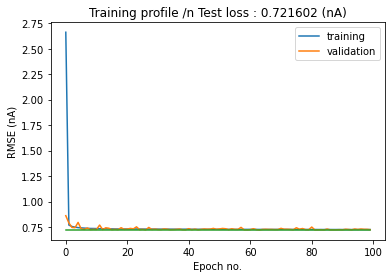

In [31]:
training_data_dir = generate_surrogate_model(training_configs)

In [27]:
os.listdir(training_data_dir)

['TEST_error.png',
 'TEST_error_vs_output.png',
 'training_data.pt',
 'TRAINING_error.png',
 'TRAINING_error_vs_output.png',
 'training_profile.png',
 'VALIDATION_error.png',
 'VALIDATION_error_vs_output.png']

In [48]:
training_data_dir

'tmp/smg\\jupyter_notebook_examples_2022_08_16_171320\\training_data_2022_08_16_214753'